In [ ]:
# ==============================================================================
# 2. IMPORT LIBRARY YANG DIBUTUHKAN
# ==============================================================================
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    Trainer,
    TrainingArguments,  
)

In [3]:
# ==============================================================================
# 3. PERSIAPAN DATA (VERSI BERSIH)
# ==============================================================================
import pandas as pd
from sklearn.model_selection import train_test_split

try:
    df = pd.read_csv(r'E:\Python - Project\INDONERIS 2025\INDONERIS-DATAMINING\INDONERIS-DATAMINING1\multimodal-hoax-detection\data\training\multimodal_splits\text_only_dataset.csv')
    print(f"Data awal dimuat. Jumlah baris: {len(df)}")
except FileNotFoundError:
    print("Error: Pastikan file 'text_only_dataset.csv' sudah di-upload.")

df_cleaned = df.drop_duplicates(subset=['title'])
print(f"Data setelah dibersihkan dari duplikat judul. Jumlah baris: {len(df_cleaned)}")
df_cleaned = df_cleaned[['title', 'label']].copy()

label_map = {'valid': 1, 'hoax': 0}
df_cleaned['labels'] = df_cleaned['label'].map(label_map)

df_train, df_val = train_test_split(
    df_cleaned,
    test_size=0.2,
    random_state=42,
    stratify=df_cleaned['labels']
)

print(f"Jumlah data latih bersih: {len(df_train)}")
print(f"Jumlah data evaluasi bersih: {len(df_val)}")

Data awal dimuat. Jumlah baris: 3276
Data setelah dibersihkan dari duplikat judul. Jumlah baris: 3270
Jumlah data latih bersih: 2616
Jumlah data evaluasi bersih: 654


In [4]:
# ==============================================================================
# 4. TOKENISASI DATA
# ==============================================================================
MODEL_NAME = 'indobenchmark/indobert-base-p1'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_data(examples):
    return tokenizer(examples['title'], padding='max_length', truncation=True, max_length=128)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_texts = df_train['title'].tolist()
val_texts = df_val['title'].tolist()
train_labels = df_train['labels'].tolist()
val_labels = df_val['labels'].tolist()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [5]:
import torch
import transformers

print(torch.__version__)
print(transformers.__version__)


2.6.0+cpu
4.57.3


In [6]:
# ==============================================================================
# 5. MEMBANGUN DAN MELATIH MODEL
# ==============================================================================

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Memindahkan model ke device: {device}")
model.to(device)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("Memulai pelatihan model...")
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Memindahkan model ke device: cpu
Memulai pelatihan model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.456200,0.248017,0.914373,0.932854,0.915294,0.951100
2,0.191400,0.308873,0.917431,0.933002,0.947103,0.919315
3,0.150400,0.489874,0.879205,0.895916,0.971429,0.831296
4,0.135100,0.405535,0.926606,0.941320,0.941320,0.941320
5,0.020800,0.455981,0.923547,0.939024,0.936740,0.941320


TrainOutput(global_step=1635, training_loss=0.19035171989436242, metrics={'train_runtime': 3575.4678, 'train_samples_per_second': 3.658, 'train_steps_per_second': 0.457, 'total_flos': 235258283484000.0, 'train_loss': 0.19035171989436242, 'epoch': 5.0})

In [7]:
# ==============================================================================
# 6. EVALUASI MODEL
# ==============================================================================
print("Pelatihan selesai. Mengevaluasi model...")
eval_results = trainer.evaluate()

print("\n--- Hasil Evaluasi Akhir ---")
print(f"Akurasi: {eval_results['eval_accuracy']:.4f}")
print(f"F1 Score: {eval_results['eval_f1']:.4f}")
print(f"Precision: {eval_results['eval_precision']:.4f}")
print(f"Recall: {eval_results['eval_recall']:.4f}")

Pelatihan selesai. Mengevaluasi model...



--- Hasil Evaluasi Akhir ---
Akurasi: 0.9144
F1 Score: 0.9329
Precision: 0.9153
Recall: 0.9511


Mendapatkan prediksi dari model pada data evaluasi...

Skor AUC-ROC: 0.9698
Nama kelas untuk grafik (Urutan 0, 1): ['hoax', 'valid']


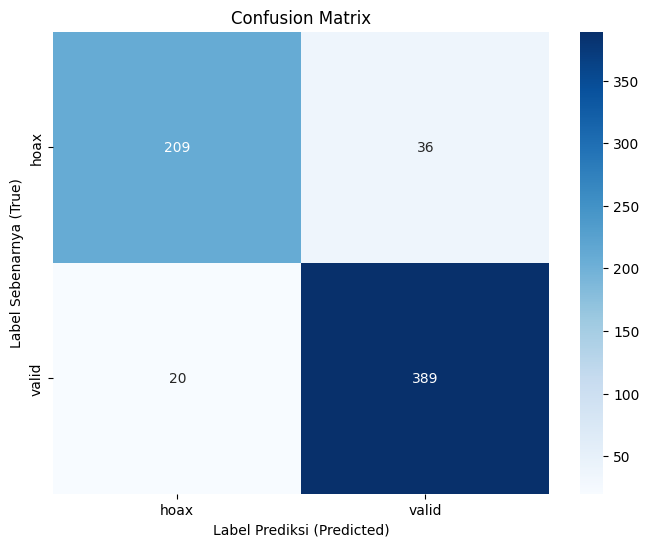

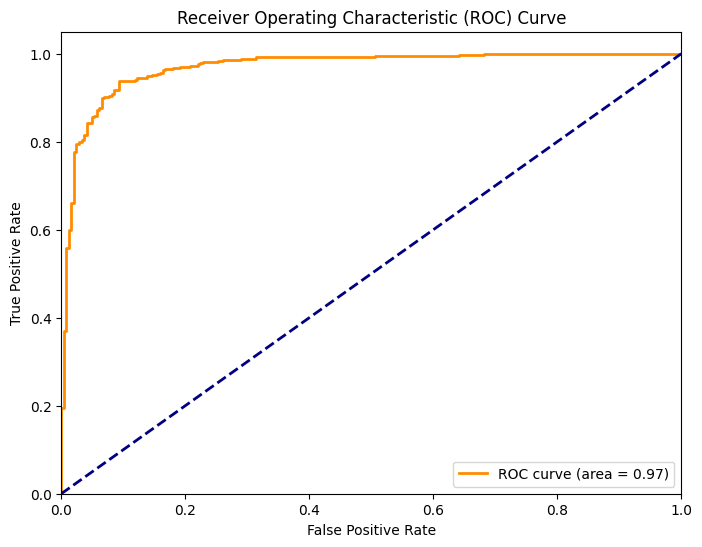

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from scipy.special import softmax
import pandas as pd


label_map = {'valid': 1, 'hoax': 0}

print("Mendapatkan prediksi dari model pada data evaluasi...")
pred_results = trainer.predict(val_dataset)

true_labels = pred_results.label_ids
logits = pred_results.predictions

predicted_classes = np.argmax(logits, axis=1)

probabilities = softmax(logits, axis=1)
proba_positive_class = probabilities[:, 1]

auc_score = roc_auc_score(true_labels, proba_positive_class)
print(f"\nSkor AUC-ROC: {auc_score:.4f}")


reverse_label_map = {v: k for k, v in label_map.items()}
class_names = [reverse_label_map[0], reverse_label_map[1]]
print(f"Nama kelas untuk grafik (Urutan 0, 1): {class_names}")

try:
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(true_labels, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Label Sebenarnya (True)')
    plt.xlabel('Label Prediksi (Predicted)')

    fpr, tpr, thresholds = roc_curve(true_labels, proba_positive_class)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

except Exception as e:
    print(f"\nTerjadi error saat membuat plot: {e}")

In [9]:
# ==============================================================================
# 7. (OPSIONAL) MENCOBA PREDIKSI
# ==============================================================================

text_berita_baru = "Menkeu Purbaya Jebloskan Luhut ke Penjara"
text_berita_valid = "Tokoh Muslimat NU Arifatul Choiri Fauzi Jadi Menteri PPPA Kabinet Prabowo-Gibran"

def prediksi_berita(teks):
    inputs = tokenizer(teks, return_tensors='pt', truncation=True, padding=True, max_length=256)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    prediksi_angka = torch.argmax(logits, dim=-1).item()

    reverse_label_map = {v: k for k, v in label_map.items()}

    return reverse_label_map[prediksi_angka]

print("\n--- Mencoba Prediksi ---")
print(f"Teks: '{text_berita_baru}' -> Prediksi: {prediksi_berita(text_berita_baru)}")
print(f"Teks: '{text_berita_valid[:50]}...' -> Prediksi: {prediksi_berita(text_berita_valid)}")


--- Mencoba Prediksi ---
Teks: 'Menkeu Purbaya Jebloskan Luhut ke Penjara' -> Prediksi: hoax
Teks: 'Tokoh Muslimat NU Arifatul Choiri Fauzi Jadi Mente...' -> Prediksi: valid


In [10]:
# ==============================================================================
# SIMPAN MODEL
# ==============================================================================

MODEL_TITLE_PATH = r"D:\INDONERIS-DATAMINING\multimodal-hoax-detection\models\text_baseline/indobert-base-p1"

print(f"Menyimpan model 'title' (Akurasi 91.9%) ke folder {MODEL_TITLE_PATH}...")

try:
    trainer.save_model(MODEL_TITLE_PATH)
    tokenizer.save_pretrained(MODEL_TITLE_PATH)
    print("Model dan Tokenizer 'title' berhasil disimpan!")
    print(f"Folder Anda '{MODEL_TITLE_PATH}' sekarang siap di-download.")
except NameError:
    print("Error: 'trainer' atau 'tokenizer' tidak ditemukan.")
    print("Pastikan Anda baru saja menyelesaikan pelatihan 'title' di notebook ini.")


Menyimpan model 'title' (Akurasi 91.9%) ke folder D:\INDONERIS-DATAMINING\multimodal-hoax-detection\models\text_baseline/indobert-base-p1...
Model dan Tokenizer 'title' berhasil disimpan!
Folder Anda 'D:\INDONERIS-DATAMINING\multimodal-hoax-detection\models\text_baseline/indobert-base-p1' sekarang siap di-download.
